# thal2 1:3 Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 1:3

In [11]:
het_coeffs = [1,100]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (1,3)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 13 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

In [13]:
etup = (.001,.2,100)

In [14]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-.01,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-0.028,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# # for i in range(4):
# #     draw_quick_plot_f(axs[i],data_b1_list,a)

<Axes: >

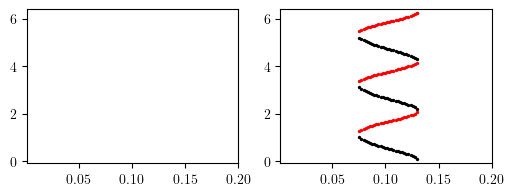

In [15]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-.1,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

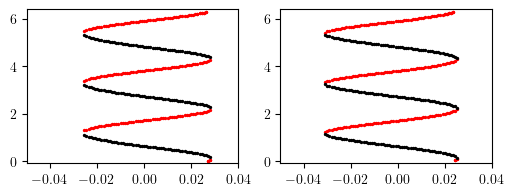

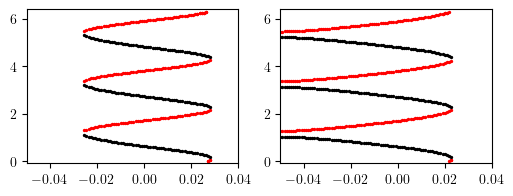

In [16]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

## EPS VARY

In [17]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [18]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [19]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.025

#### Branches eps stable

In [20]:
b=.025
kw_b['recompute'] = False
kw_b['b'] = b

In [21]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.03,eps_final=0,deps=-.005),
            dict(phi0=3,eps_init=0.029,eps_final=0.2,deps=.005)]

In [22]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3
phi init 3


In [23]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [24]:
kw_b['recompute'] = False
kw_b['b'] = b

In [25]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [26]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=13_b=0.025_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=13_b=0.025_ei=0.05_ef=0_de=-2.txt


In [27]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=4,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [28]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=13_b=0.025_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=13_b=0.025_ei=0.05_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=13_b=0.025_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=4_nm=13_b=0.025_ei=0.049_ef=0.2_de=0.01.txt


In [29]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

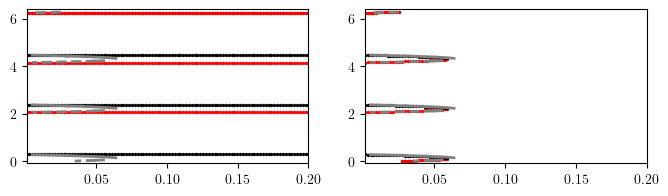

In [30]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [31]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.064 0.1399077638224
phi init 0.1399077638224
Y [-1.09467290e-01  2.31192267e-01  9.25748460e-02  3.98324962e-01 -3.34770854e-01  6.28010901e-01  9.10950738e-02  9.19413247e-06  6.25127897e+00]
mkdir ./data/thal2_13_b0=0.025/
* Loading LC data...
self.T 6.279803287849821
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.001287710162796289
es_min,phi0 0.0635 0.1399077638224
phi init 0.1399077638224
Y [-1.09435995e-01  2.29205978e-01  9.25842907e-02  4.00688328e-01 -3.35607042e-01  6.28483542e-01  9.11629106e-02  9.24057135e-06  6.25138950e+00]
mkdir ./data/thal2_13_b1=0.025/
* Loading LC data...
self.T 6.279472568327425
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0014107155118192457
es_min,phi0 0.063 0.1399077638224
phi init 0.1399077638224
Y [-1.09427991e-01  2.30427447e-01  9.26050724e-02  3.99256791e-01 -3.40909482e-01  6.31400071e-01  9.12596092e-02  9.48496325e-06  6.25150750e+00]
mkdir ./data/thal2_13_b

In [32]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.022

#### Branches eps stable

In [33]:
b=.022
kw_b['recompute'] = False
kw_b['b'] = b

In [34]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.03,eps_final=0,deps=-.005),
            dict(phi0=3,eps_init=0.029,eps_final=0.2,deps=.005)]

In [35]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3
phi init 3


In [36]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [37]:
kw_b['recompute'] = False
kw_b['b'] = b

In [38]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [39]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=13_b=0.022_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=13_b=0.022_ei=0.05_ef=0_de=-2.txt


In [40]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=4,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [41]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=13_b=0.022_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=13_b=0.022_ei=0.05_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=13_b=0.022_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=4_nm=13_b=0.022_ei=0.049_ef=0.2_de=0.01.txt


In [42]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

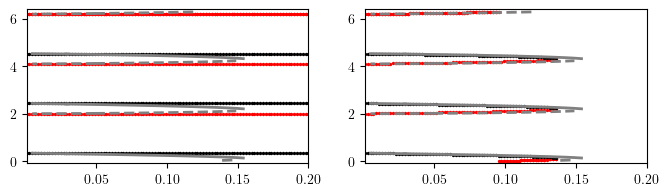

In [43]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [44]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.15400000000000003 0.12985047375532943
phi init 0.12985047375532943
Y [-1.12095137e-01  2.31913632e-01  9.11156134e-02  3.95200972e-01 -3.21066469e-01  6.21313325e-01  8.59320094e-02  9.13688035e-06  6.21291244e+00]
mkdir ./data/thal2_13_b0=0.022/
* Loading LC data...
self.T 6.212912431897554
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.007281667720859735
es_min,phi0 0.15350000000000003 0.12985047375532943
phi init 0.12985047375532943
Y [-1.12063652e-01  2.26906233e-01  9.11166987e-02  4.01222059e-01 -3.15167087e-01  6.17606724e-01  8.59771019e-02  8.97510283e-06  6.21285109e+00]
mkdir ./data/thal2_13_b1=0.022/
* Loading LC data...
self.T 6.212851076836981
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.007821010314714012
es_min,phi0 0.15300000000000002 0.12985047375532943
phi init 0.12985047375532943
Y [-1.12044054e-01  2.29304344e-01  9.11447965e-02  3.98359748e-01 -3.23221048e-01  6.22649959e-01  8.60931

In [45]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.021

#### Branches eps stable

In [46]:
b=.021
kw_b['recompute'] = False
kw_b['b'] = b

In [47]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=3,eps_init=0.03,eps_final=0,deps=-.005),
            dict(phi0=3,eps_init=0.029,eps_final=0.2,deps=.005)]

In [48]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 3
phi init 3


In [49]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [50]:
kw_b['recompute'] = False
kw_b['b'] = b

In [51]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [52]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=13_b=0.021_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=13_b=0.021_ei=0.05_ef=0_de=-2.txt


In [53]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=4,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=4,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [54]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=13_b=0.021_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=13_b=0.021_ei=0.05_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=13_b=0.021_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=4_nm=13_b=0.021_ei=0.049_ef=0.2_de=0.01.txt


In [55]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

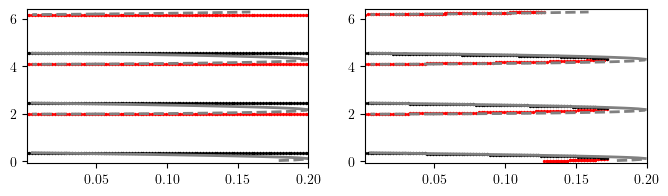

In [56]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [57]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.025

#### Branches eps stable

In [58]:
b=-.025
kw_b['recompute'] = False
kw_b['b'] = b

In [59]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [60]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [61]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [62]:
kw_b['recompute'] = False
kw_b['b'] = b

In [63]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [64]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4.3,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4.3
phase_diffs_u_init=4.3_nm=13_b=-0.025_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.3_nm=13_b=-0.025_ei=0.05_ef=0_de=-2.txt


In [65]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [66]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=13_b=-0.025_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=13_b=-0.025_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=13_b=-0.025_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=13_b=-0.025_ei=0.049_ef=0.2_de=0.01.txt


In [67]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

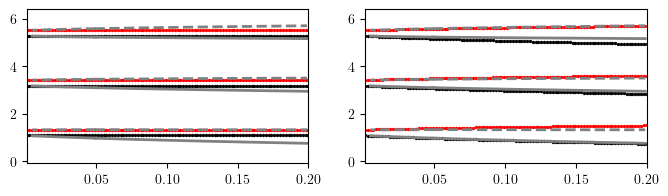

In [68]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [69]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.028

#### Sim

In [70]:
# a=a;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [71]:
# # show original system
# a=a;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [72]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [73]:
b=-.028
kw_b['recompute'] = False
kw_b['b'] = b

In [74]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.005)]

In [75]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [76]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [77]:
kw_b['recompute'] = False
kw_b['b'] = b

In [78]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [79]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4.3,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4.3
phase_diffs_u_init=4.3_nm=13_b=-0.028_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.3_nm=13_b=-0.028_ei=0.05_ef=0_de=-2.txt


In [80]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [81]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=13_b=-0.028_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=13_b=-0.028_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=13_b=-0.028_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=13_b=-0.028_ei=0.049_ef=0.2_de=0.01.txt


In [82]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

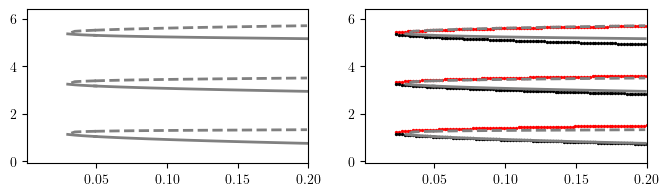

In [83]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [84]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.030000000000000013 1.1239187778277655
phi init 1.1239187778277655
Y [-1.09815948e-01  2.31458937e-01  9.00055781e-02  3.96926824e-01 -6.06717854e-01  4.72719216e-01  9.68242301e-02  4.22442195e-03  6.21329116e+00]
mkdir ./data/thal2_13_b0=-0.028/
* Loading LC data...
self.T 6.213291352555026
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0015966998188866007
es_min,phi0 0.030500000000000013 1.1239187778277655
phi init 1.1239187778277655
Y [-1.09833876e-01  2.25538309e-01  8.99301957e-02  4.03912043e-01 -6.05171437e-01  4.77141862e-01  9.69138783e-02  3.98338153e-03  6.21215870e+00]
mkdir ./data/thal2_13_b1=-0.028/
* Loading LC data...
self.T 6.212158894335578
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0017434017493091806
es_min,phi0 0.031000000000000014 1.1239187778277655
phi init 1.1239187778277655
Y [-1.09879019e-01  2.24908506e-01  8.98747919e-02  4.04612768e-01 -6.04645394e-01  4.78619958e-01  9.6937

In [85]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.04

#### Branches eps stable

In [86]:
b=-.04
kw_b['recompute'] = False
kw_b['b'] = b

In [87]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.149,eps_final=0.2,deps=.005)]

In [88]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [89]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [90]:
kw_b['recompute'] = False
kw_b['b'] = b

In [91]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [92]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3.8,eps_init=0.15,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.04_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.04_ei=0.15_ef=0_de=-2.txt


In [93]:
#### in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.8,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=3.8,eps_init=0.149,eps_final=0.2,deps=.01),
           ]

In [94]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.04_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.04_ei=0.15_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.04_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.04_ei=0.149_ef=0.2_de=0.01.txt


In [95]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

In [96]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.04_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.04_ei=0.15_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.04_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.04_ei=0.149_ef=0.2_de=0.01.txt


In [97]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

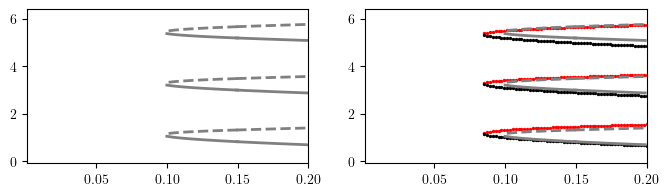

In [98]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [99]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.09999999999999995 1.043297438369569
phi init 1.043297438369569
Y [-1.14712135e-01  2.26902384e-01  8.27489047e-02  3.96329507e-01 -6.04209535e-01  4.58313352e-01  9.28645440e-02  4.98221066e-03  6.06827196e+00]
mkdir ./data/thal2_13_b0=-0.04/
* Loading LC data...
self.T 6.068272109047323
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.007385932105292719
es_min,phi0 0.10049999999999995 1.043297438369569
phi init 1.043297438369569
Y [-1.14748196e-01  2.24783760e-01  8.27308293e-02  3.98897164e-01 -6.03094607e-01  4.61597269e-01  9.29899115e-02  4.77841591e-03  6.06728713e+00]
mkdir ./data/thal2_13_b1=-0.04/
* Loading LC data...
self.T 6.067287275198094
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00806744021648628
es_min,phi0 0.10099999999999995 1.043297438369569
phi init 1.043297438369569
Y [-1.14794018e-01  2.23394843e-01  8.27138213e-02  4.00564467e-01 -6.02180560e-01  4.64288903e-01  9.30956523e-02  4.61

In [100]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.06

#### Branches eps stable

In [101]:
b=-.06
kw_b['recompute'] = False
kw_b['b'] = b

In [102]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.149,eps_final=0.2,deps=.005)]

In [103]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [104]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [105]:
kw_b['recompute'] = False
kw_b['b'] = b

In [106]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [107]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3.8,eps_init=0.15,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.06_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.06_ei=0.15_ef=0_de=-2.txt


In [108]:
#### in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.8,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=3.8,eps_init=0.149,eps_final=0.2,deps=.01),
           ]

In [109]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.06_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.06_ei=0.15_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.06_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.06_ei=0.149_ef=0.2_de=0.01.txt


In [110]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

In [111]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.06_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.06_ei=0.15_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.06_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.06_ei=0.149_ef=0.2_de=0.01.txt


In [112]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

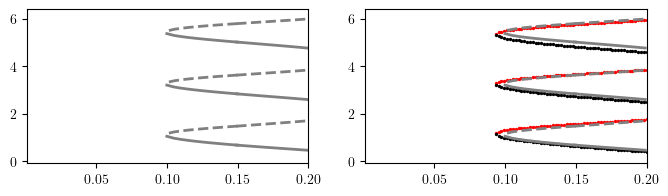

In [113]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [114]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.09999999999999995 1.043297438369553
phi init 1.043297438369553
Y [-1.14712136e-01  2.26902494e-01  8.27489051e-02  3.96329370e-01 -6.04209561e-01  4.58313290e-01  9.28645428e-02  4.98221467e-03  6.06827196e+00]
mkdir ./data/thal2_13_b0=-0.06/
* Loading LC data...
self.T 6.068272109049227
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.007385932100653212
es_min,phi0 0.10049999999999995 1.043297438369553
phi init 1.043297438369553
Y [-1.14740494e-01  2.25666153e-01  8.27810852e-02  3.97821358e-01 -6.02474302e-01  4.64120869e-01  9.31547806e-02  4.63079754e-03  6.06727103e+00]
mkdir ./data/thal2_13_b1=-0.06/
* Loading LC data...
self.T 6.067271163377678
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00892606735448006
es_min,phi0 0.10099999999999995 1.043297438369553
phi init 1.043297438369553
Y [-1.14783067e-01  2.23686740e-01  8.28029551e-02  4.00222900e-01 -6.00715067e-01  4.69498709e-01  9.34016330e-02  4.32

In [115]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.08

#### Branches eps stable

In [116]:
b=-.08
kw_b['recompute'] = False
kw_b['b'] = b

In [117]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.149,eps_final=0.2,deps=.005)]

In [118]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [119]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [120]:
kw_b['recompute'] = False
kw_b['b'] = b

In [121]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [122]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3.8,eps_init=0.15,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.08_ei=0.15_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.08_ei=0.15_ef=0_de=-2.txt


In [123]:
#### in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.8,eps_init=0.15,eps_final=0,deps=-.005),
            dict(phi0=3.8,eps_init=0.149,eps_final=0.2,deps=.01),
           ]

In [124]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.08_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.08_ei=0.15_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.08_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.08_ei=0.149_ef=0.2_de=0.01.txt


In [125]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

In [126]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.08_ei=0.15_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.08_ei=0.15_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.08_ei=0.149_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.08_ei=0.149_ef=0.2_de=0.01.txt


In [127]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

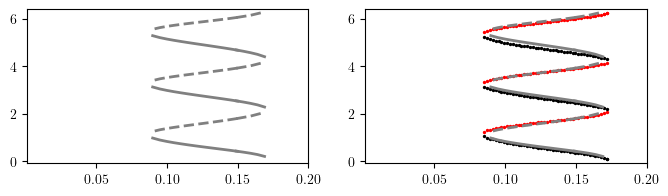

In [128]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [129]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08999999999999994 0.9705649510499068
phi init 0.9705649510499068
Y [-1.14006802e-01  2.30691041e-01  8.42977959e-02  3.92664161e-01 -5.93750021e-01  4.95731108e-01  9.53250259e-02  3.04680398e-03  6.08918943e+00]
mkdir ./data/thal2_13_b0=-0.08/
* Loading LC data...
self.T 6.089189431490283
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.015971096556254828
es_min,phi0 0.09049999999999994 0.9705649510499068
phi init 0.9705649510499068
Y [-1.13996705e-01  2.29068260e-01  8.43323493e-02  3.94646807e-01 -5.91888718e-01  5.00349376e-01  9.54998434e-02  2.84970209e-03  6.08869245e+00]
mkdir ./data/thal2_13_b1=-0.08/
* Loading LC data...
self.T 6.0886924585755375
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.017180467385888944
es_min,phi0 0.09099999999999994 0.9705649510499068
phi init 0.9705649510499068
Y [-1.14003054e-01  2.28214743e-01  8.43676832e-02  3.95682627e-01 -5.90273857e-01  5.04322165e-01  9.56523448e-

#### Monodromys max

In [130]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.169 0.1975793403884838
phi init 0.1975793403884838
Y [-1.12635044e-01  2.31725907e-01  9.10927114e-02  3.94860377e-01 -3.88995077e-01  6.52804665e-01  8.73270980e-02  1.52818212e-05  6.19474539e+00]
mkdir ./data/thal2_13_b0=-0.08/
* Loading LC data...
self.T 6.089189431490283
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.015971096556254828
es_min,phi0 0.1685 0.1975793403884838
phi init 0.1975793403884838
Y [-1.12646692e-01  2.30583648e-01  9.10747292e-02  3.96193056e-01 -3.94595397e-01  6.54320397e-01  8.76480714e-02  1.63883382e-05  6.19252960e+00]
mkdir ./data/thal2_13_b1=-0.08/
* Loading LC data...
self.T 6.0886924585755375
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.017180467385888944
es_min,phi0 0.168 0.1975793403884838
phi init 0.1975793403884838
Y [-1.12698102e-01  2.24744364e-01  9.10301928e-02  4.03164634e-01 -3.95910402e-01  6.54550042e-01  8.78955760e-02  1.68900276e-05  6.19039106e+00]
mkdir

In [131]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.1

#### Branches eps stable

In [132]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [133]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.099,eps_final=0.2,deps=.005)]

In [134]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [135]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [136]:
kw_b['recompute'] = False
kw_b['b'] = b

In [137]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [138]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3.8,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.1_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.1_ei=0.1_ef=0_de=-2.txt


In [139]:
#### in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=3.8,eps_init=0.1,eps_final=0,deps=-.005),
            dict(phi0=3.8,eps_init=0.099,eps_final=0.2,deps=.01),
           ]

In [140]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.1_ei=0.1_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.1_ei=0.1_ef=0_de=-0.005.txt
phi init 3.8
phase_diffs_u_init=3.8_nm=13_b=-0.1_ei=0.099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.8_nm=13_b=-0.1_ei=0.099_ef=0.2_de=0.01.txt


In [141]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

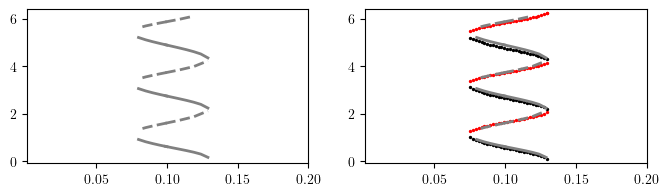

In [142]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [143]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

#### Monodromys max

In [144]:
# # get min eps
# es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_max_temp = []
# for i in range(5):
#     ee = es_max-0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_max_temp.append(ee)

# b_max_all.append(b)
# eigenvalues_max_all.append(eigenvalues_temp)
# e_vals_mono_max.append(es_max_temp)
# #m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [145]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [146]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

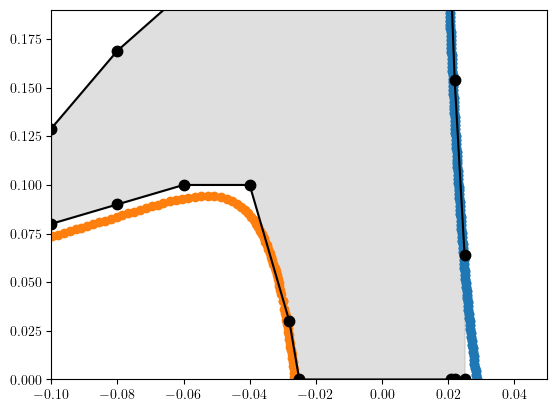

In [147]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

# split_idx = np.where(np.isnan(data[:,0]))[0][0]

# br1 = data[:split_idx]
# br2 = data[split_idx+1:]

# axs.plot(br1[:,0],br1[:,1],color='r',marker='.')
# axs.plot(br2[:,0],br2[:,1],color='r',marker='.')

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

In [148]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

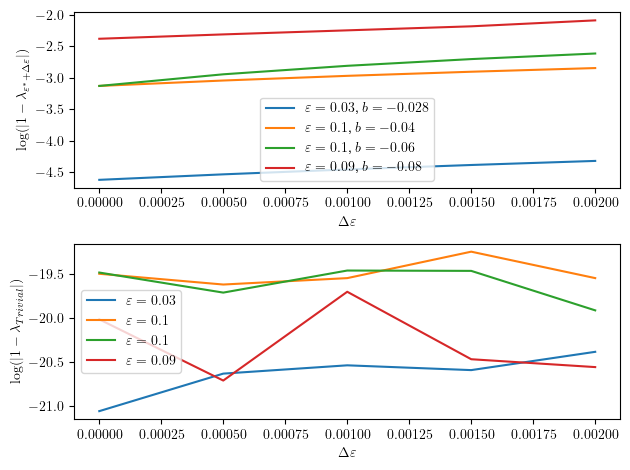

In [149]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

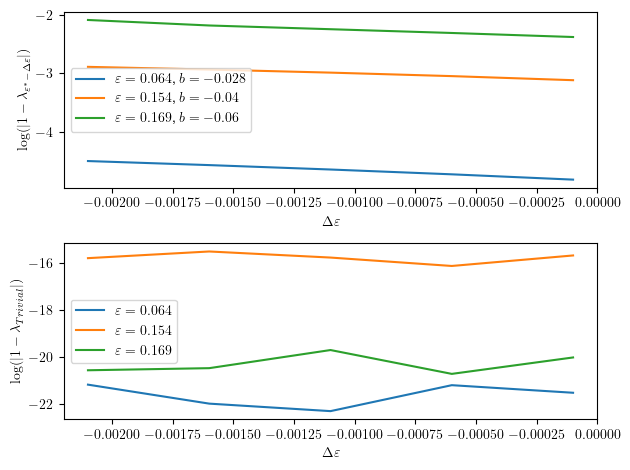

In [150]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))